In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Pre trained models

In [2]:
import inspect
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
model_dictionary

{'DenseNet121': <function tensorflow.python.keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)>,
 'DenseNet169': <function tensorflow.python.keras.applications.densenet.DenseNet169(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)>,
 'DenseNet201': <function tensorflow.python.keras.applications.densenet.DenseNet201(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)>,
 'EfficientNetB0': <function tensorflow.python.keras.applications.efficientnet.EfficientNetB0(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax', **kwargs)>,
 'EfficientNetB1': <function tensorflow.python.keras.applications.efficientnet.EfficientNetB1(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=

## Multiple ways of checking if GPU is present

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [4]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14716167635555330263
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3134364059
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14907070548255643556
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [6]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [4]:
categories = ['Negative', 'Positive']

In [5]:
os.chdir('data/crack_detect')
if os.path.isdir('train/Negative/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for category in categories:
        shutil.move(f'{category}', 'train')
        os.mkdir(f'valid/{category}')
        os.mkdir(f'test/{category}')
        
        valid_samples = random.sample(os.listdir(f'train/{category}'), 1000)
        for i in valid_samples:
            shutil.move(f'train/{category}/{i}', f'valid/{category}')
            
        test_samples = random.sample(os.listdir(f'train/{category}'), 250)
        for j in test_samples:
            shutil.move(f'train/{category}/{j}', f'test/{category}')
os.chdir('../..')

In [6]:
train_path = 'data/crack_detect/train'
valid_path = 'data/crack_detect/valid'
test_path = 'data/crack_detect/test'

## Preprocess Images

In [21]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=50)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=50)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=50, shuffle=False)

Found 37500 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


## Loading InceptionV3 (GoogLeNet)

In [8]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [9]:
incept = InceptionV3()
incept.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

conv2d_35 (Conv2D)              (None, 17, 17, 128)  114688      activation_34[0][0]              
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 17, 17, 128)  384         conv2d_35[0][0]                  
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 17, 17, 128)  0           batch_normalization_35[0][0]     
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 17, 17, 128)  98304       mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 17, 17, 128)  114688      activation_35[0][0]              
__________________________________________________________________________________________________
batch_norm

average_pooling2d_6 (AveragePoo (None, 17, 17, 768)  0           mixed6[0][0]                     
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 17, 17, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 17, 17, 192)  258048      activation_62[0][0]              
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 17, 17, 192)  258048      activation_67[0][0]              
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 17, 17, 192)  147456      average_pooling2d_6[0][0]        
__________________________________________________________________________________________________
batch_norm

In [13]:
len(incept.layers)

313

Exclude last layer

In [14]:
x = incept.layers[-2].output

In [15]:
output = Dense(units=2, activation='softmax')(x)

In [16]:
model = Model(inputs=incept.input, outputs=output)

## Freezing all layers except last layer

In [17]:
for layer in model.layers[:-2]:
    layer.trainable = False

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

conv2d_65 (Conv2D)              (None, 17, 17, 192)  258048      activation_64[0][0]              
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 17, 17, 192)  576         conv2d_65[0][0]                  
__________________________________________________________________________________________________
activation_65 (Activation)      (None, 17, 17, 192)  0           batch_normalization_65[0][0]     
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 17, 17, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 17, 17, 192)  258048      activation_65[0][0]              
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 8, 8, 384)    442368      activation_86[0][0]              
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 8, 8, 384)    442368      activation_90[0][0]              
__________________________________________________________________________________________________
conv2d_92 (Conv2D)              (None, 8, 8, 384)    442368      activation_90[0][0]              
__________________________________________________________________________________________________
average_pooling2d_8 (AveragePoo (None, 8, 8, 2048)   0           mixed9[0][0]                     
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 8, 8, 320)    655360      mixed9[0][0]                     
__________

# Train the model

In [19]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(x=train_batches,
         steps_per_epoch=len(train_batches),
         validation_data=valid_batches,
         validation_steps=len(valid_batches),
         epochs=5,
         verbose=1
         )

Epoch 1/5
750/750 [==============================] - 1249s 2s/step - loss: 0.0242 - accuracy: 0.9945 - val_loss: 0.0263 - val_accuracy: 0.9925
Epoch 2/5
750/750 [==============================] - 205s 272ms/step - loss: 0.0189 - accuracy: 0.9953 - val_loss: 0.0240 - val_accuracy: 0.9930
Epoch 3/5
750/750 [==============================] - 256s 341ms/step - loss: 0.0156 - accuracy: 0.9959 - val_loss: 0.0199 - val_accuracy: 0.9940
Epoch 4/5
750/750 [==============================] - 438s 584ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.0178 - val_accuracy: 0.9950
Epoch 5/5
750/750 [==============================] - 216s 288ms/step - loss: 0.0116 - accuracy: 0.9965 - val_loss: 0.0168 - val_accuracy: 0.9955


# Predictions

In [23]:
predictions = model.predict(x=test_batches, verbose=0)

In [24]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [25]:
test_batches.class_indices

{'Negative': 0, 'Positive': 1}

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix, without normalization
[[250   0]
 [  0 250]]


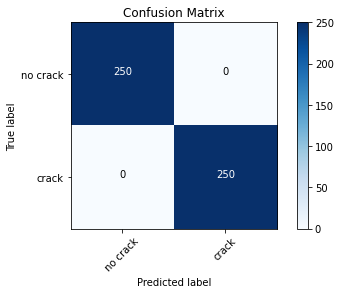

In [28]:
cm_plot_labels = ['no crack', 'crack']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')